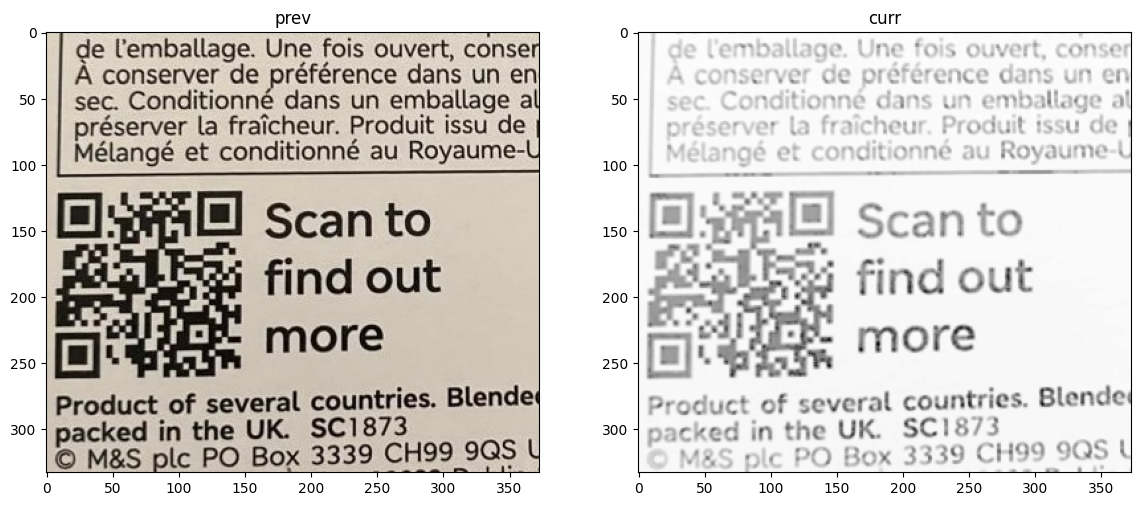

In [58]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

from ipcv import cvlib, scanner
from importlib import reload
from scipy import stats as st
from utility import notebook_helper

reload(cvlib)
reload(scanner)
reload(notebook_helper)

# Set custom color (opencv uses BGR not RGB)
BLUE = (0, 0, 255)
GREEN = (0, 255, 0)
RED = (255, 0, 0)


# # A function to display side-by-side visuals for comparisons and swaps previous and current data for continues processing.
# def display_and_swap(data, curr_img, curr_label, display=True):
#     # Display the previous and current side-by-side for visual comparison.
#     if display:
#         plt.figure(figsize=(14, 12))
#         plt.subplot(1, 2, 1)
#         plt.imshow(data['prev'], cmap='gray')
#         plt.title(data['prev_label'])
#
#         plt.subplot(1, 2, 2)
#         plt.imshow(curr_img, cmap='gray')
#         plt.title(curr_label)
#
#     # Swap data for subsequent execution.
#     data['prev'] = curr_img
#     data['prev_label'] = curr_label
#
#     data['curr'] = None
#     data['curr_label'] = None
#
#     return data

# A function to display side-by-side visuals for comparisons and swaps previous and current data for continues processing.
def display_and_swap(prev_img, curr_img):
    # Display the previous and current side-by-side for visual comparison.
    if display:
        plt.figure(figsize=(14, 12))
        plt.subplot(1, 2, 1)
        plt.imshow(prev_img, cmap='gray')
        plt.title('prev')

        plt.subplot(1, 2, 2)
        plt.imshow(curr_img, cmap='gray')
        plt.title('curr')


# Load the image as RGB.
# 100 is tricky because has black background.
# image = cvlib.load_image('resources/qr-code/qrcode100.png')

# 600 is difficult because cannot remove the bigger box with text!
# image = cvlib.load_image('resources/qr-code/qrcode600.jpeg')


# image = cvlib.load_image('resources/qr-code/qrcode500.jpeg')

# image = cvlib.load_image('resources/qr-code/qrcode310.jpg')

# Working
# image = cvlib.load_image('../resources/qr-code/qrcode200.jpg')
image = cvlib.load_image('../resources/qr-code/qrcode201.jpg')
# image = cvlib.load_image('../resources/qr-code/qrcode400.jpg')

gamma = 0.1
gaussian_ksize = (3, 3)
gaussian_sigma = 2
pre = scanner.preprocess_image(image, gamma, gaussian_ksize, gaussian_sigma)
display_and_swap(image, pre)

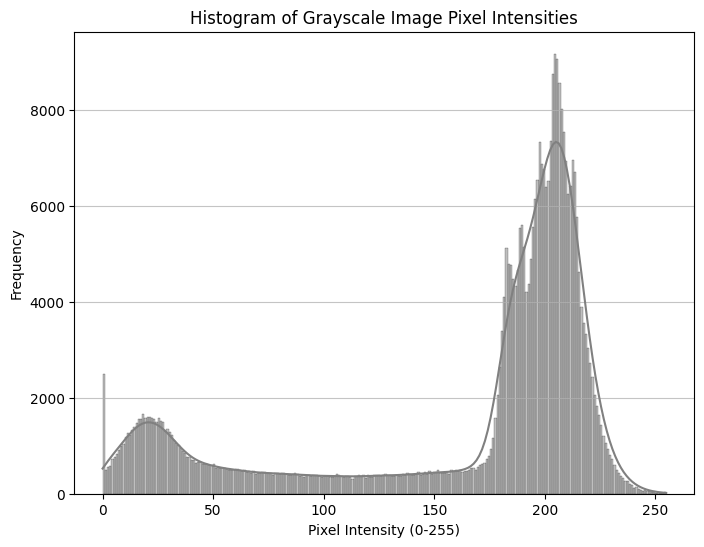

In [59]:
# Let's analyze the original grayscale's histogram.
notebook_helper.display_histograms(image, 'Histogram of Grayscale Image Pixel Intensities')

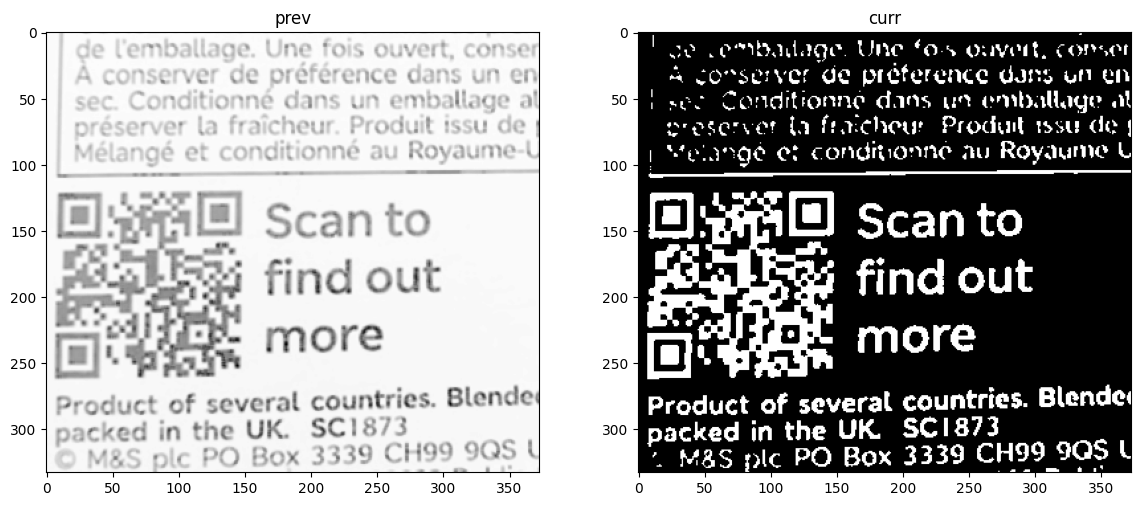

In [60]:
label = 'thresh'
thresh = 128
# curr = cvlib.binarize(dat['prev'], thresh)
# After high gamma exposure, otsu is needed, otherwise all becomes darker.
binary = cv2.threshold(pre, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

# Display and swap for data for next operation.
display_and_swap(pre, binary)

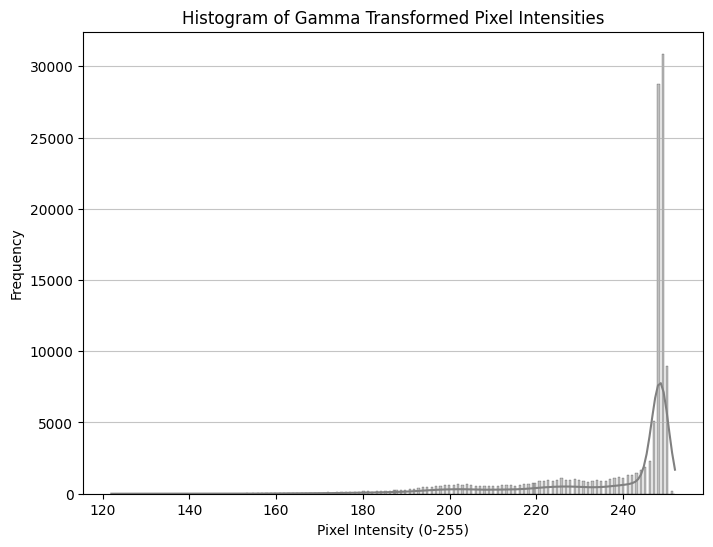

In [61]:
# Let's analyze the gamma transformed grayscale's histogram.
notebook_helper.display_histograms(pre, 'Histogram of Gamma Transformed Pixel Intensities')

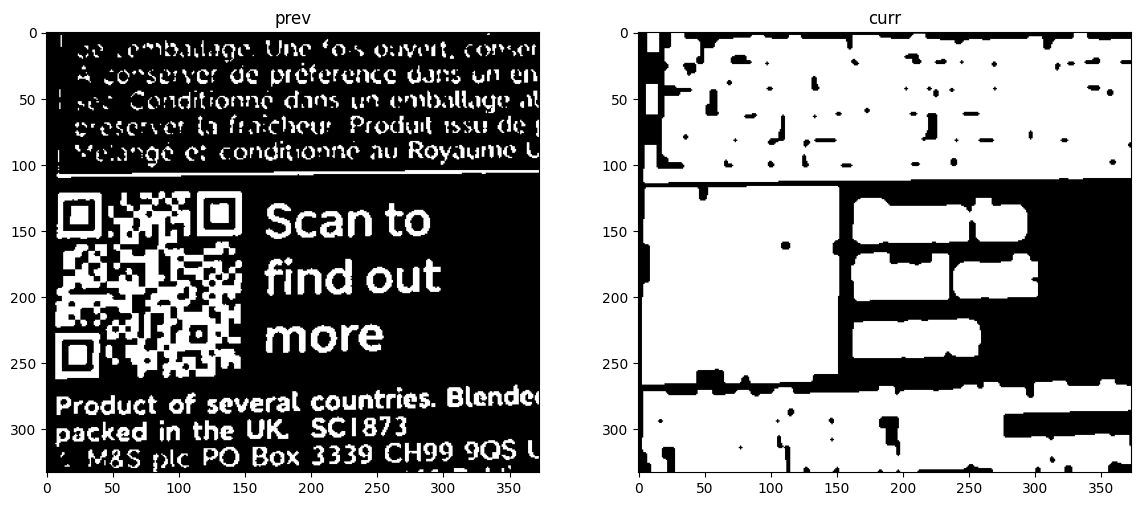

In [62]:
vertical = cv2.getStructuringElement(cv2.MORPH_CROSS, (1, 3))
horizontal = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 1))
rect = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))
p = binary
for i in range(1, 3):
    p = cv2.dilate(p, vertical, iterations=3)
    p = cv2.dilate(p, horizontal, iterations=3)
    # p = cv2.morphologyEx(p, cv2.MORPH_OPEN, rect)
    p = cv2.erode(p, horizontal, iterations=2)
    p = cv2.erode(p, vertical, iterations=2)
    # p = cv2.dilate(p, rect, iterations=1)
    p = cv2.morphologyEx(p, cv2.MORPH_CLOSE, rect)
    p = cv2.dilate(p, vertical, iterations=1)
    p = cv2.dilate(p, horizontal, iterations=1)
    # p = cv2.morphologyEx(p, cv2.MORPH_OPEN, rect)
    p = cv2.morphologyEx(p, cv2.MORPH_CLOSE, rect)

display_and_swap(binary, p)

Image Area: 124209
Required ratio: 2760.2
Number of contours found: 9

Calculated area: 20078.0
Calculate ratio: 5.6923076923076925

Calculated area: 2531.5
Calculate ratio: 3.730769230769231

Calculated area: 1679.0
Calculate ratio: 2.3703703703703702

Calculated area: 2195.5
Calculate ratio: 2.0555555555555554

Calculated area: 3557.0
Calculate ratio: 3.742857142857143

Calculated area: 20983.0
Calculate ratio: 0.9866666666666667
Max-Area: 20983.0

Calculated area: 176.0
Calculate ratio: 0.391304347826087

Calculated area: 37258.5
Calculate ratio: 3.324324324324324

Calculated area: 120.0
Calculate ratio: 0.5625



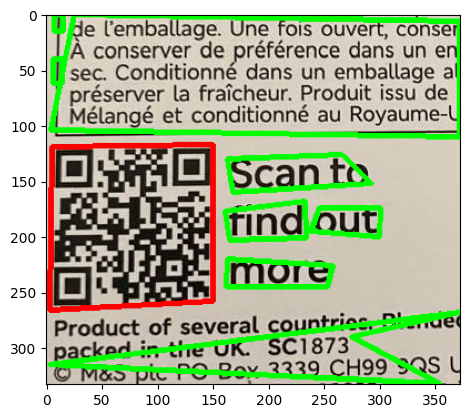

In [63]:
contours, _ = cv2.findContours(p, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

image_area = image.shape[0] * image.shape[1]
required_aspect_ration = image_area / 45

print(f'Image Area: {image_area}')
print(f'Required ratio: {required_aspect_ration}')
cropped = None
print(f'Number of contours found: {len(contours)}\n')

max_contour = None
max_area = 0
for contour in contours:
    # print(f'\nContour len: {len(contour)}')
    perimeter = cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, 0.04 * perimeter, True)
    # print(f'Approx len: {len(approx)}')
    cv2.drawContours(image, [approx], -1, GREEN, 3)
    if len(approx) == 4:
        area = cv2.contourArea(contour)
        print(f'Calculated area: {area}')

        (x, y, w, h) = cv2.boundingRect(approx)
        aspect_ratio = w / float(h)
        print(f'Calculate ratio: {aspect_ratio}')

        # Ensure the QR-Code is a box shaped (max ratio of w:h = 1.2:1)
        # AND min area => 12 x 10
        # if area > 100 and 0.8 <= aspect_ratio <= 1.2:
        if area > required_aspect_ration and 0.8 <= aspect_ratio <= 1.2:
            # if area > required_aspect_ration :
            # if 0.8 <= aspect_ratio <= 1.2:
            if area > max_area:
                max_area = area
                print(f'Max-Area: {max_area}')
                max_contour = contour
        print('\r')

if max_contour is not None:
    perimeter = cv2.arcLength(max_contour, True)
    approx = cv2.approxPolyDP(max_contour, 0.04 * perimeter, True)
    cv2.drawContours(image, [approx], -1, RED, 3)
    (x, y, w, h) = cv2.boundingRect(approx)
    cropped = image[y:y + h, x:x + w]

plt.imshow(image)

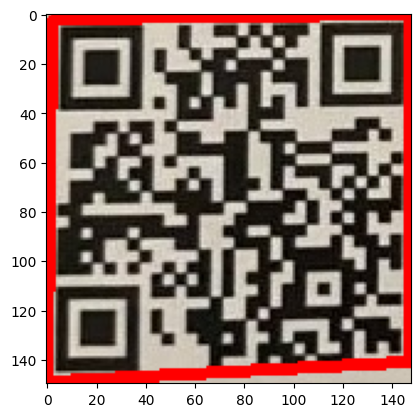

In [64]:
if cropped is not None:
    plt.imshow(cropped, cmap='gray')